In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import datetime 

from dateutil.relativedelta import relativedelta
#импорт библиотек

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(25,25)}
        )

In [2]:
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg') # данные о заказе

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_month'] = orders.order_purchase_timestamp.dt.month_name()
orders['year'] = orders.order_purchase_timestamp.dt.year
# Сразу привожу колонку с датой заказа к нужному типу и из нее для удобства извлекаю месяц и год в отдельную колонку

customers = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig')

items = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')


## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Прежде чем выполнять задание, необходимо определить, что считать успешной покупкой покупкой.

Покупка в данном проекте (в этом задании и далее) это заказ, который был оплачен и не был отменен. То есть заказ может быть не только доставлен, но и на этапе сборки и доставки.
Успешной считается покупка со статусами processing, shipped и delivered.

In [3]:
customers_orders = customers.merge(orders, how='inner', on = 'customer_id') # мерджим таблицы по customer_id,

customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,year
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,May,2017
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,January,2018
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,May,2018
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,March,2018
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,July,2018


In [4]:
purchases = customers_orders.query("order_status in ['processing ', 'shipped ', 'delivered']") \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id':'count'}) \
    .sort_values('order_id', ascending=False)
# производим группировку по customer_unique_id и подсчитывает количество заказов для кажддого уник. клиента
purchases.head()

,customer_unique_id,order_id
51431,8d50f5eadf50201ccdcedfb9e2ac8455,15
22779,3e43e6105506432c953e165fb2acf44c,9
36706,6469f99c1f9dfae7733b25662e7f1782,7
73921,ca77025e7201e3b30c44b472ff346268,7
10060,1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [5]:
one_purchase = purchases.query("order_id == 1")
# фильтруем только клиентов, совершивших 1 заказ.

## Ответ

In [6]:
one_purchase.shape

(90557, 2)

## 90557 пользователей сделало только 1 заказ

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Во второй задаче необходимо понять почему заказ может быть недоставлен.
Заказы, которые находятся в работе мы не затрагиваем, так как их окончательный статус не ясен, недоставленным может быть заказ если он отменен клиентом или если необходимого товара нет на площадке (canceled, unavailable)

In [7]:
non_deliver = orders.query("order_status in ['canceled' , 'unavailable'] ") \
    .groupby(['order_month', 'year', 'order_status'], as_index=False) \
    .agg({'order_id':'count'}) \
    .groupby(['order_month', 'order_status'], as_index=False) \
    .agg({'order_id':'mean'}) \
    .rename(columns={'order_id':'orders'})
non_deliver.head()

# Отсеиваем доставленные заказы и производим группировку по месяцам и статусам заказа
# считаем количесвто недоставленных заказов по всем группам.
# выводим детализацию по месяцам

,order_month,order_status,orders
0,April,canceled,16.5
1,April,unavailable,7.0
2,August,canceled,55.5
3,August,unavailable,19.5
4,December,canceled,11.0


In [8]:
non_deliver = non_deliver.groupby('order_status', as_index=False) \
    .agg({'orders':'mean'}) \
    .round(2)
# для каждой причины считаем среднее количество недоставленных заказов в месяц

## Ответ

In [9]:
non_deliver

,order_status,orders
0,canceled,26.78
1,unavailable,32.21


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [10]:
order_items = orders.merge(items, how='inner', on='order_id')
order_items.order_purchase_timestamp = order_items.order_purchase_timestamp.dt.day_name()
order_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,year,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,Monday,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,October,2017,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,Tuesday,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,July,2018,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,Wednesday,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,August,2018,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,Saturday,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,November,2017,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,Tuesday,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,February,2018,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [11]:
order_items = order_items.query("order_status in ['processing ', 'shipped ', 'delivered']")

In [12]:
order_items = order_items.dropna()

In [13]:
order_items_by_week = order_items.groupby(['product_id','order_purchase_timestamp'],as_index=False) \
    .agg({'order_id':'count'}) \
    .sort_values('order_id', ascending=False) \
    .drop_duplicates(subset=["product_id"], keep='first') \
    .rename(columns={'order_purchase_timestamp':'weekday', 'order_id':'orders'}) \


## Ответ

In [14]:
order_items_by_week

,product_id,weekday,orders
15592,422879e10f46682990de24d770e7f83d,Wednesday,93
35742,99a4788cb24856965c36a24e339b6058,Monday,91
40173,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19704,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12740,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
23482,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
23484,641444946fe3a839d726c32804cd1aff,Tuesday,1
23485,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1
23486,64187b994e1b15e6a59a6f72688fbea8,Friday,1


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [15]:
customers_orders['weeks'] = orders.order_purchase_timestamp.dt.daysinmonth / 7

# сначала считаем сколько полных недель в месяце

In [16]:
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,year,weeks
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,May,2017,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,January,2018,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,May,2018,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,March,2018,4.285714
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,July,2018,4.000000


In [17]:
orders_by_weeks = customers_orders.query("order_status in ['processing', 'shipped', 'delivered']") \
    .groupby(['customer_unique_id', 'order_month', 'year', 'weeks'], as_index=False) \
    .agg({'order_id':'count'}) \
    .sort_values('order_id') \
    .rename(columns={'order_id':'orders'}) \
    .groupby(['customer_unique_id', 'order_month', 'weeks'], as_index=False) \
    .agg({'orders':'mean'})

orders_by_weeks.head()

# Для успешных покупок производим группировку и считаем кол-во заказов.
# проводим повторную группировку и выводим среднее количество заказов . Важно провести вторую группировку
# чтобы заказы, созданные в один месяц но в разные годы не суммировались и не исказили среднее

,customer_unique_id,order_month,weeks,orders
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1.0
2,0000f46a3911fa3c0805444483337064,March,4.000000,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1.0
4,0004aac84e0df4da2b147fca70cf8255,November,4.428571,1.0


In [18]:
orders_by_weeks['orders'] = orders_by_weeks.orders / orders_by_weeks.weeks

# делим средние заказы в месяц на кол-во недель и получаем среднее в неделю

## Ответ

In [19]:
orders_by_weeks

,customer_unique_id,order_month,weeks,orders
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,March,4.000000,0.250000
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,4.428571,0.225806
...,...,...,...,...
97263,fffcf5a5ff07b0908bd4e2dbc735a684,June,4.428571,0.225806
97264,fffea47cd6d3cc0a88bd621562a9d061,December,4.000000,0.250000
97265,ffff371b4d645b6ecea244b27531430a,February,4.428571,0.225806
97266,ffff5962728ec6157033ef9805bacc48,May,4.000000,0.250000


## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц

Перед проведением когортного анализа определяют четыре параметра:

1. Признак формирования когорты — действие, которое объединяет людей в группу: первая покупка.

2. Размер когорты — временной интервал: месяц.

3. Отчетный период — 3 месяца.

4. Анализируемый ключевой показатель: Retention Rate.

In [20]:
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,year,weeks
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,May,2017,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,January,2018,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,May,2018,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,March,2018,4.285714
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,July,2018,4.000000


In [21]:
customers_orders['year_month'] = customers_orders.order_purchase_timestamp.dt.to_period('M')

# Приводим каждую дату заказа к формату год-месяц, так как более подробное разделение на дни, часы и т.д. не требуется

In [22]:
first_purchase = customers_orders.query("order_status in ['processing ', 'shipped ', 'delivered']") \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'year_month': 'min'}) \
    .rename(columns={'year_month':'first_order'})
first_purchase.head()

# Для каждого customer_unique_id определяем месяц когда была совершена первая покупка
# Вспоминаем, что успешной покупкой мы считаем все оплаченные заказы, которые не были отменены

,customer_unique_id,first_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [23]:
customer_cohorts = customers_orders.merge(first_purchase, how='inner', on='customer_unique_id')
customer_cohorts.head()

#Мерджим таблицу со всеми заказами с таблицей, где мы вывели месяц первой покупки.

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,year,weeks,year_month,first_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,May,2017,4.428571,2017-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,January,2018,4.428571,2018-01,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,May,2018,4.428571,2018-05,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,March,2018,4.285714,2018-03,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,July,2018,4.000000,2018-07,2018-07


In [24]:
cohorts_groupped = customer_cohorts.groupby(['first_order','year_month']) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'orders'})
cohorts_groupped


# Здесь мы начинаем строить когорту. Так как нам необходимо посчитать индекс возвращаемости клиентов
# группировку производим по first_order и order_purchase_timestamp, чтобы понять сколько заказов 
# и в какие месяцы совершались покупки

# Производим аггрегацию по order_id и считаем кол-во заказов по каждому месяцу

orders
first_order year_month        
2016-09     2016-09          1
2016-10     2016-10        265
            2017-04          1
            2017-07          1
            2017-09          1
...                        ...
2018-08     2017-12          2
            2018-05          1
            2018-08       6187
            2018-09          5
            2018-10          2

[267 rows x 1 columns]

In [25]:
def retention(df):
    df['another_order'] = np.arange(len(df)) + 1
    return df

cohorts_groupped = cohorts_groupped.groupby(level=0).apply(retention)
cohorts_groupped


# Создаем функцию, в которой мы считаем кол-во месяцев, в течение которых отобранные по дате первой покупке клиенты,
# совершали повторные покупки

orders  another_order
first_order year_month                       
2016-09     2016-09          1              1
2016-10     2016-10        265              1
            2017-04          1              2
            2017-07          1              3
            2017-09          1              4
...                        ...            ...
2018-08     2017-12          2              4
            2018-05          1              5
            2018-08       6187              6
            2018-09          5              7
            2018-10          2              8

[267 rows x 2 columns]

In [26]:
cohorts_pivot = cohorts_groupped \
    .pivot_table(columns = 'another_order', index = 'first_order', values = 'orders')
cohorts_pivot.head()


# Делаем сводную таблицу, в которой можно наглядно увидеть в течение скольких месяцев когорты совершали повторные покупки

another_order,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
first_order,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,265.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,751.0,2.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1.0,1653.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0


In [27]:
starting_point = cohorts_pivot[1]
retention = cohorts_pivot.divide(starting_point, axis=0)

# Так как retention rate это коэффициент возвращаемости, необходимо посчитать долю повторных покупок
# В кач-ве отправной точки берем перый месяц, и все месяцы, когда совершались покупки делим на него

In [28]:
retention

another_order,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
first_order,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.003774,0.003774,0.003774,0.003774,0.003774,0.003774,0.007547,0.007547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002663,0.002663,0.001332,0.003995,0.001332,0.005326,0.001332,0.001332,0.003995,0.001332,0.007989,0.003995,0.001332,0.001332,0.002663,0.003995,0.001332,NaN
2017-02,1.0,1653.000000,3.000000,5.000000,2.000000,7.000000,2.000000,4.000000,3.000000,2.000000,3.000000,2.000000,5.000000,2.000000,3.000000,2.000000,1.000000,1.000000,3.0
2017-03,1.0,2542.000000,12.000000,10.000000,12.000000,9.000000,4.000000,4.000000,8.000000,8.000000,2.000000,10.000000,4.000000,5.000000,3.000000,4.000000,6.000000,2.000000,3.0
2017-04,1.0,1143.000000,7.500000,3.000000,2.500000,3.500000,3.000000,4.500000,3.500000,3.500000,2.000000,3.000000,1.000000,0.500000,0.500000,1.000000,1.000000,2.000000,NaN
2017-05,1.0,0.004823,0.004823,0.003121,0.002837,0.003404,0.004539,0.001418,0.002553,0.003688,0.002553,0.003404,0.002270,0.000284,0.001702,0.001986,NaN,NaN,NaN
2017-06,1.0,1549.000000,8.500000,6.500000,7.000000,5.000000,6.500000,5.500000,3.500000,2.000000,3.000000,4.500000,6.500000,2.500000,3.000000,5.000000,NaN,NaN,NaN


In [29]:
retention[retention[3] == retention[3].max()].index

# Теперь мы можем ответить на поставленный вопрос и вывести когорту с самым высоким показателем на 3-й месяц

PeriodIndex(['2017-11'], dtype='period[M]', name='first_order', freq='M')

## Ответ: самый высокий показатель у когорты от ноября 2017

## 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [30]:
all_data = customers.merge(orders, how='inner', on='customer_id')

In [31]:
all_data = all_data.merge(items, how='inner', on='order_id')
all_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,year,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,May,2017,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,January,2018,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,May,2018,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,March,2018,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,July,2018,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [32]:
last_purchase = all_data.query("order_status in ['processing ', 'shipped ', 'delivered']") \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'max'}) \
    .rename(columns={'order_purchase_timestamp':'last_order'})
last_purchase.head()

,customer_unique_id,last_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [33]:
all_data = all_data.merge(last_purchase, how='inner', on='customer_unique_id')

In [34]:
all_data = all_data.query("order_status in ['processing ', 'shipped ', 'delivered']")

In [35]:
all_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_estimated_delivery_date,order_month,year,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,last_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,2017-06-05 00:00:00,May,2017,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,2018-02-06 00:00:00,January,2018,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,2018-06-13 00:00:00,May,2018,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,2018-04-10 00:00:00,March,2018,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,2018-08-15 00:00:00,July,2018,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-07-29 09:51:30


In [36]:
now = datetime.datetime.now()
now

datetime.datetime(2022, 11, 19, 17, 9, 5, 66545)

In [37]:
all_data['time_delta'] = all_data.last_order - now
all_data.head()
# Вычисляем кол-во дней от последней покупки до текущей даты

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_month,year,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,last_order,time_delta
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,May,2017,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05-16 15:05:35,-2014 days +21:56:29.933455
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,January,2018,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01-12 20:48:24,-1772 days +03:39:18.933455
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,May,2018,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-05-19 16:07:45,-1646 days +22:58:39.933455
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,March,2018,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03-13 16:06:38,-1713 days +22:57:32.933455
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,July,2018,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-07-29 09:51:30,-1575 days +16:42:24.933455


In [38]:
rfm_claster = all_data.groupby(['customer_unique_id', 'last_order', 'time_delta'], as_index=False) \
    .agg({'order_id':'count', 'price':'sum'}) \
    .rename(columns={'time_delta':'recency', 'price':'monetary', 'order_id':'freqency'})

rfm_claster

,customer_unique_id,last_order,recency,freqency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,-1655 days +17:47:21.933455,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,-1658 days +18:02:21.933455,1,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,-2080 days +03:55:57.933455,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,-1864 days +03:20:35.933455,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,-1831 days +02:36:36.933455,1,180.00
...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,-1990 days +03:51:30.933455,2,1570.00
93354,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,-1805 days +02:58:50.933455,1,64.89
93355,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,-2112 days +22:40:10.933455,1,89.90
93356,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,-1663 days +22:08:35.933455,1,115.00


In [39]:
rfm_claster['recency'] = rfm_claster.recency.dt.days

# для простоты оставим от колонки только количество дней

In [40]:
rfm_claster.recency.quantile(q= [0,0.5,0.7,1])

# Проверяю какие значения попадают в перцентили для дальнецшего распределения.

0.0   -2257.0
0.5   -1762.0
0.7   -1678.0
1.0   -1544.0
Name: recency, dtype: float64

In [41]:
rfm_claster['r'] = pd.qcut(rfm_claster['recency'], q = [0,0.5,0.7,1], labels = [1,2,3])
rfm_claster['f'] = rfm_claster['freqency'].apply(lambda x: 3 if x > 2 else x)
rfm_claster['m'] = rfm_claster['monetary'].apply(lambda x: 3 if x > 5000 else 2 if x <=5000 and x > 1000 else 1)


Теперь присваиваем "очки" значениям.
Для формирования кластеров мы подсчитываем количество покупок, общую сумму покупок и дату последней покупки.
Всем кластерам мы присваем трехбальные значения, в зависимости от того, как часто совершаются покупки / как много тратится денег
Так как показатель recency привязан к текущей дате, мы не можем установить конкретные числовые границы
поэтому дату покупки определяем с помощью квантилей,
все остальные по конкретным цифрам
частоту покупок мы можем разделить на одну покупку, две и многократные

In [42]:
rfm_claster['RFM'] = rfm_claster.r.astype(str) + rfm_claster.f.astype(str) + rfm_claster.m.astype(str)
rfm_claster.head()

,customer_unique_id,last_order,recency,freqency,monetary,r,f,m,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,-1655,1,129.90,3,1,1,311
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,-1658,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,-2080,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,-1864,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,-1831,1,180.00,1,1,1,111


In [43]:
rfm_claster_summary = rfm_claster.groupby('RFM', as_index=False) \
    .agg({'customer_unique_id':'count'}) \
    .sort_values('customer_unique_id', ascending=False)

## Ответ

In [44]:
rfm_claster_summary

,RFM,customer_unique_id
0,111,40744
15,311,24215
9,211,16048
3,121,4311
18,321,2634
11,221,1759
6,131,1296
20,331,850
13,231,563
1,112,377


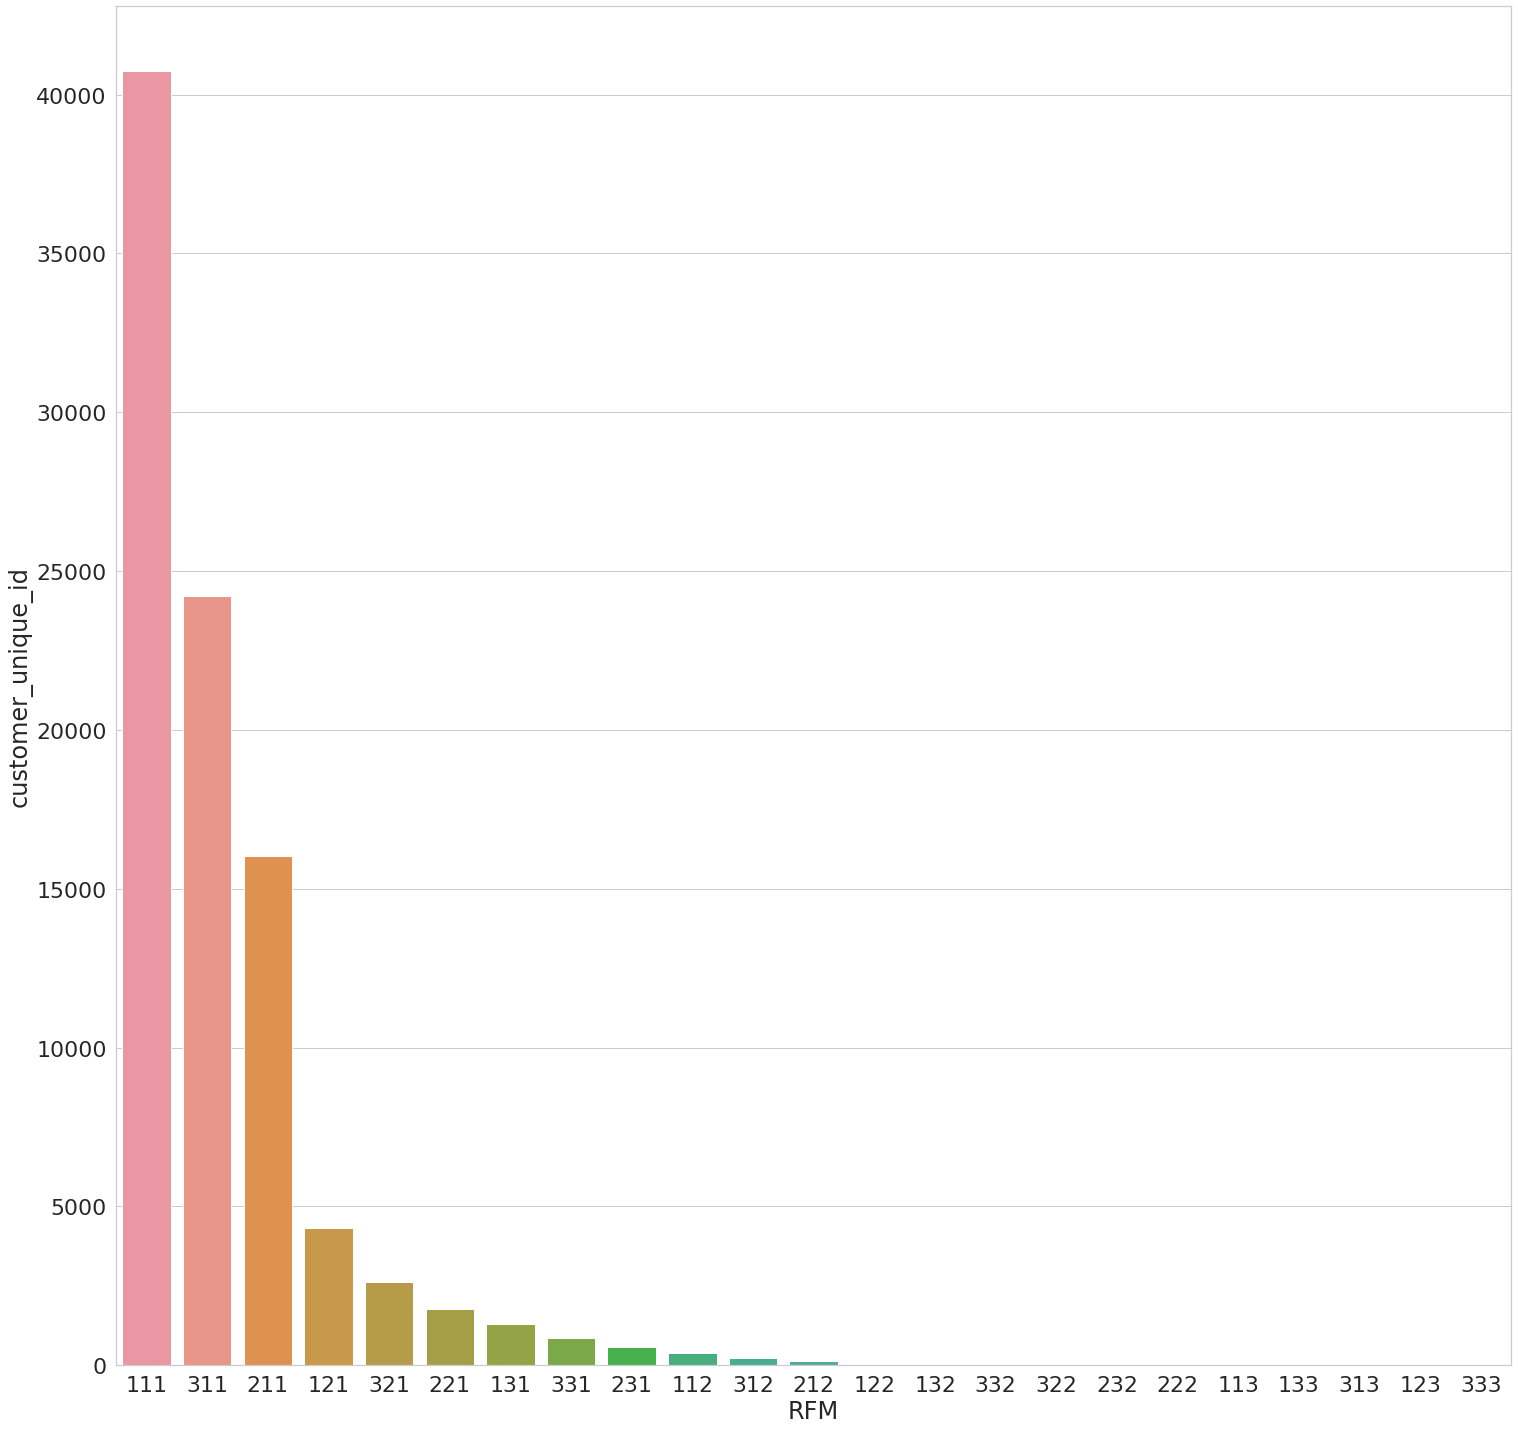

In [47]:
sns.barplot(data = rfm_claster_summary, x= 'RFM', y = 'customer_unique_id') 

    Таким образом получили для каждого клиента трехзначный код, комбинация которого может определить его лояльность.
Чем выше каждая цифра в коде тем более лояльный клиент.
Мы посчитали количество пользователей, которые попадают под каждый из вариантов комбинации и получили результат, который показал, что клиентов, совершивших одноразовую покупку и потратили небольшое количество денег (до 1000 рублей) большинство, причем во всех временных отрезках (RFM 111, 211, 311).

Меньше всего пользователей, который совершают покупки на крупные суммы (113, 133, 313, 123, 333).